In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy.engine import Engine
from pathlib import Path
import yaml

In [2]:
# Настроим подключение к базе данных
CONFIG_PATH = "config.yaml"
with open(CONFIG_PATH, "r", encoding="utf-8") as config_file:
    CONFIG = yaml.load(config_file, Loader=yaml.FullLoader)

CON = create_engine(
    CONFIG['database_url']
)

def select(query: str, con: Engine = CON) -> pd.DataFrame:
    """
    Функция обобщённого sql-запроса к базе данных соцсети, содержащей три таблицы:
    1. Данные пользователей user
    2. Данные постов post
    3. Данные действий пользователей в соцсети feed
    """
    return pd.read_sql(query, con)

### Исследуем таблицу пользователей

In [3]:
# Посмотрим таблицу юзеров
q = """
SELECT *
FROM public.user
"""

user_data = select(q)
user_data.head()

,id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


In [10]:
user_data.id.nunique(), user_data.shape[0]

(163205, 163205)

In [12]:
user_data.id.min(), user_data.id.max()

(200, 168552)

In [22]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163205 entries, 0 to 163204
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         163205 non-null  int64 
 1   gender     163205 non-null  int64 
 2   age        163205 non-null  int64 
 3   country    163205 non-null  object
 4   city       163205 non-null  object
 5   exp_group  163205 non-null  int64 
 6   os         163205 non-null  object
 7   source     163205 non-null  object
dtypes: int64(4), object(4)
memory usage: 10.0+ MB


Получается, что id пользователей принимают значения от 200 до 168552, при этом отсутствует около 5000 id.
Для обработки ситуации с передачей в запрос несуществующего id, добавим в сервис следующее.

In [29]:
# Пусть пришел запрос от пользователя с неизвестным id.
# Воспользуемся следующей логикой - показать что-то лучше, чем выдать ошибку и не показать ничего.
# Тогда пусть для неизвестных id будет выдаваться лента "усредненного пользователя" - 
# виртуального пользователя с наиболее часто встречающимися признаками

mean_user = {
    "gender": user_data.gender.mode().values[0],
    "age": user_data.age.mode().values[0],
    "country": user_data.country.mode().values[0],
    "city": user_data.city.mode().values[0],
    "exp_group": user_data.exp_group.mode().values[0],
    "os": user_data.os.mode().values[0],
    "source": user_data.source.mode().values[0],
}

mean_user

{'gender': 1,
 'age': 20,
 'country': 'Russia',
 'city': 'Moscow',
 'exp_group': 3,
 'os': 'Android',
 'source': 'ads'}

### Теперь таблицу постов


In [15]:
q = """
SELECT *
FROM public.post
"""

post_data = select(q)
post_data.head()

,id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


In [18]:
post_data.id.nunique(), post_data.shape[0]

(7023, 7023)

In [19]:
post_data.id.min(), post_data.id.max()

(1, 7319)

In [21]:
post_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7023 entries, 0 to 7022
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7023 non-null   int64 
 1   text    7023 non-null   object
 2   topic   7023 non-null   object
dtypes: int64(1), object(2)
memory usage: 164.7+ KB


Пропусков нет

### Таблица взаимодействия

In [32]:
# Посмотрим временные рамки всего доступного датасета

In [33]:
q = """
SELECT MIN(timestamp), MAX(timestamp)
FROM public.feed_data
"""

timestamp_limits = select(q)
timestamp_limits

,min,max
0,2021-10-01 06:01:40,2021-12-29 23:51:06


In [54]:
q = """
WITH q1 (timestamp, user_id, post_id, action, target, num) AS 
(
    SELECT timestamp, user_id, post_id, action, target, ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY timestamp DESC) AS num
    FROM public.feed_data
    WHERE action = 'view'
)
SELECT timestamp, user_id, post_id, target
FROM q1
WHERE num <= 75
"""

feed_data = select(q)
feed_data.head()

,timestamp,user_id,post_id,target
0,2021-12-29 15:24:59,200,1773,0
1,2021-12-29 15:24:31,200,2213,1
2,2021-12-29 15:23:54,200,1122,0
3,2021-12-29 15:23:29,200,1362,0
4,2021-12-29 15:21:53,200,1541,0


In [55]:
feed_data.describe()

,user_id,post_id,target
count,8.160250e+06,8.160250e+06,8.160250e+06
mean,8.507037e+04,3.390067e+03,1.261766e-01
std,4.897149e+04,2.093269e+03,3.320484e-01
min,2.000000e+02,1.000000e+00,0.000000e+00
25%,4.103000e+04,1.522000e+03,0.000000e+00
50%,8.551100e+04,3.177000e+03,0.000000e+00
75%,1.277330e+05,5.197000e+03,0.000000e+00
max,1.685520e+05,7.319000e+03,1.000000e+00


In [56]:
feed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8160250 entries, 0 to 8160249
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   timestamp  datetime64[ns]
 1   user_id    int64         
 2   post_id    int64         
 3   target     int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 249.0 MB


In [57]:
feed_data.timestamp.min(), feed_data.timestamp.max()

(Timestamp('2021-10-20 13:50:05'), Timestamp('2021-12-29 23:51:06'))

In [58]:
feed_data.isna().sum()

timestamp    0
user_id      0
post_id      0
target       0
dtype: int64

In [59]:
feed_data.nunique()

timestamp    296096
user_id      163205
post_id        6831
target            2
dtype: int64

In [60]:
feed_data.shape

(8160250, 4)

Всего база данных включает в себя логи за 2 месяца - с 22.10.2021 по 29.12.2021

Посмотрим на размеры выгруженного датасета, если последние две недели отсечем для проведения синтетического A\B теста

In [63]:
max_date = feed_data.timestamp.max()
feed_data[(max_date - feed_data.timestamp).dt.days > 7 ].shape

(3400521, 4)

<AxesSubplot:>

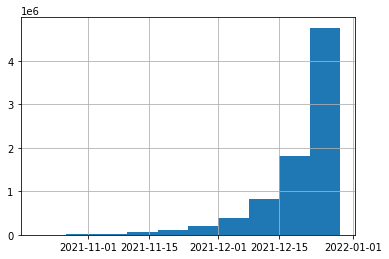

In [64]:
feed_data.timestamp.dt.date.hist()

In [65]:
q = """
SELECT * 
FROM public.feed_data 
LIMIT 10000000
"""

uniform_feed_data = select(q)
uniform_feed_data.head()

MemoryError: 